In [1]:
%%capture
!pip install --upgrade spacy
!python -m spacy download es
import statistics
import requests
import spacy
import re
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup

# Mapa de Dependencias de la Administración Pública Nacional

El objetivo de esta notebook es obtener una representación de las depencias del estado que permita identificar aquellas que tienen solapamiento de sus competencias con otras.

Para ello, hemos obtenido información pública sobre las dependencias, descripciones textuales de sus objetivos y su posición en el organigrama del estado.

Hemos desarrollado métricas de interés basadas en ejemplos clasificados por un experto de dominio.

El objetivo de estas métricas es justamente identificar cuándo un par de dependencias tienen solapamiento de competencias entre ellas. También las hemos usado para identificar conjuntos de dependencias con solapamiento entre ellas.

---

## Construyendo la Base de Datos


Se construye un listado de dependencias del estado a partir de tres fuentes de datos donde se extrajo el téxto de los objetivos y competencias de cada organismo presentado y la información sobre a quien debe reportarse. Para cada una de estas fuentes se construyó un dataframe que luego se unifica en la Base de Datos:

En el texto crudo se reemplazan los saltos de linea y los índices presentes.

* ### [Secretarías. Subsecretarías y similares](http://servicios.infoleg.gob.ar/infolegInternet/anexos/330000-334999/333535/texact.htm)  
Nota: algunos nombres quedan incompletos, se podría extrapolar la información según los vecinos.

In [2]:
def get_infoleg_raw_text(url):
  if url == "":
    return ""
  page = requests.get(url)
  soup = BeautifulSoup(page.content,  "html.parser")
  [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
  visible_text = soup.getText()
  return visible_text


url = 'http://servicios.infoleg.gob.ar/infolegInternet/anexos/330000-334999/333535/texact.htm'

raw_text = get_infoleg_raw_text(url)

#pequeña limpieza 
text = re.sub(r'\([^)]*\)', '', raw_text)
text = re.sub(r'[X|V|I]+.-', '', text)

#Dividimos el texto según la palabra OBJETIVOS (ver url)
texts = [list(filter(None,i)) for i in [re.split("\n",x) for x in text.split("OBJETIVOS")] if list(filter(None,i))]

data = []

#Extraemos las relaciones de dependencia
for i in range(len(texts)-1):
    entes = []
    for txt in texts[i][-5:]:
        if txt.lstrip().startswith(("MINISTERIO","SECRETARÍA","SUBSECRETARÍA","UNIDAD","CASA","PRESIDENCIA", "JEFATURA", "OFICINA", "INSTITUTO")):
            entes += [txt.lstrip()]
    data += [entes]
    data = list(filter(None, data))
     
#extraemos el texto de los objetivos (el último paso es especial, ver url)
for i in range(1,len(data)+1):
    if i != len(data):
        data[i-1] += [' '.join(texts[i][:-2])]
    else:
        data[i-1] += [' '.join(texts[i][:-2]).split("2019-111894517-APN-DNO#")[0]]

#Control de errores
for i,ls in enumerate(data):
    if len(ls) == 2:
        data[i] = [""]+ls
    if len(ls) == 4:
        data[i] = ls[1:]
    if len(ls) == 5:
        data[i] = ls[2:]

data = [x for x in data if x]

secret_df = pd.DataFrame(data=data, columns=["reporta_a", "organismo_ente", "raw_text"])
secret_df = secret_df[["organismo_ente", "raw_text", "reporta_a"]]
secret_df["centralizado"] = True

* ### [Ministerios - LEY DE MINISTERIOS](http://servicios.infoleg.gob.ar/infolegInternet/anexos/330000-334999/333138/norma.htm)


In [3]:
url = 'http://servicios.infoleg.gob.ar/infolegInternet/anexos/330000-334999/333138/norma.htm'
raw_text = get_infoleg_raw_text(url)

#Dividimos y limpiamos el texto para dejar solo los objetivos de cada ministerio
texts = raw_text.replace("\n", " ").split("Compete al")[1:]
texts = [re.sub(r'asistir.*:','     ',txt) for txt in texts]
texts = [x.split("     ") for x in texts]

mini_df = pd.DataFrame(data=texts, columns=["organismo_ente", "raw_text"])
mini_df["organismo_ente"] = mini_df["organismo_ente"].str.strip()
mini_df["centralizado"] = True

* ### [Organismos Descentralizados](https://mapadelestado.jefatura.gob.ar/includes/estructura_csv.php?r=2)

In [4]:
def get_norma_url(s): 
    """quiero pasar de esto:
    'http://servicios.infoleg.gob.ar/infolegInternet/verNorma.do?id=279040'
    a esto:
    'http://servicios.infoleg.gob.ar/infolegInternet/anexos/275000-279999/279040/norma.htm'
    """  
    base = 'http://servicios.infoleg.gob.ar/infolegInternet/anexos/'
    try:
        id = re.search(r'\d+', s)[0]
        num = int(int(id) / 5000) * 5000
        url = base + f'{num}-{num+4999}/{id}/norma.htm'
    except TypeError:
        return ""
    return url

#extraemos la DB que provee el mapa del estado
DB_URL = "https://mapadelestado.jefatura.gob.ar/includes/estructura_csv.php?r=2"
descen_df = pd.read_csv(DB_URL,  sep=",", index_col=False)
descen_df.rename(columns = {'\tjurisdiccion':'jurisdiccion'}, inplace = True)
columnas = ['organismo_ente', "jurisdiccion", 'subjurisdiccion', 'reporta_a', 'tipo_administracion', 'norma_competencias_objetivos', 'web']
descen_df = descen_df[columnas]

descen_df["centralizado"] = False
#Hacemos un poco de Limpieza
descen_df.norma_competencias_objetivos = descen_df.norma_competencias_objetivos.str.replace(r'\[(.*?)\]','',regex=True)
descen_df.norma_competencias_objetivos = descen_df.norma_competencias_objetivos.str.replace(r'\(|\)','',regex=True)
descen_df.norma_competencias_objetivos = descen_df.norma_competencias_objetivos.str.replace(r';',' ',regex=True)
descen_df.norma_competencias_objetivos = descen_df.norma_competencias_objetivos.str.split()

#extraemos los textos de los links de infoLEG que se proveen
descen_df.norma_competencias_objetivos = descen_df.norma_competencias_objetivos.agg(lambda x: ['http'+xi for line in x for xi in line.split('http')])
descen_df.norma_competencias_objetivos = descen_df.norma_competencias_objetivos.agg(lambda x: [url for url in x if "infoleg" in url])
descen_df.norma_competencias_objetivos = descen_df.norma_competencias_objetivos.agg(lambda x: [get_norma_url(url) if "verNorma" in url else url for url in x ])
descen_df["raw_text"] = descen_df.norma_competencias_objetivos.agg(lambda x: [get_infoleg_raw_text(url) for url in x ])
descen_df.index.rename('idx', inplace=True)
descen_df2 = descen_df.explode(column="raw_text")
descen_df2.reset_index(inplace=True)

---

## Procesamiento del Texto

Tokenizacion, lematización y filtrado de stopwords del texto

Para la información extraida de los organismos descentralizados se dividen los documentos de una misma dependencia para reducir la carga computacional, luego esto se vuelve a unificar. En este paso se aplican procesamientos específicos para tal razón.


In [2]:
nlp = spacy.load("es_core_news_sm")

In [3]:
centralizados = [secret_df, mini_df]
centr_df = pd.concat(centralizados, axis=0, ignore_index=True)

centr_df["reporta_a"] = centr_df["reporta_a"].str.strip()

centr_df["proc_text"] = centr_df["raw_text"]
centr_df["proc_text"] = centr_df["proc_text"].str.replace(r'\d\.', '', regex=True)
centr_df["proc_text"] = centr_df["proc_text"].str.strip()
centr_df["proc_text"] = centr_df["proc_text"].str.lower()

docs = nlp.pipe(centr_df.proc_text.astype(str), disable=[ 'toc2vec', 'attribute_ruler', "ner"], batch_size=50, n_process=3)

doc_list = []
for doc in docs:
    st = ""
    for token in doc:
        #Filtro de stopwords y de símbolos de puntuación
        if not token.is_stop and not token.is_punct:
            st += str.strip(token.lemma_)+' '
    doc_list += [st]

centr_df['proc_text'] = np.array(doc_list)

NameError: name 'secret_df' is not defined

In [7]:
#volvemos todo a minúscula
descen_df2['proc_text'] = descen_df2.raw_text.str.lower()
#removemos los saltos de linea
descen_df2.proc_text = descen_df2.proc_text.str.replace("\n", ' ', regex=True)
#removemos números
descen_df2.proc_text = descen_df2.proc_text.str.replace(r'\d', '', regex=True)
#removemos los espacios en blanco de más
descen_df2.proc_text = descen_df2.proc_text.replace(r'\s+', ' ', regex=True)

docs = nlp.pipe(descen_df2.proc_text.astype(str), disable=[ 'toc2vec', 'attribute_ruler', "ner"], batch_size=50, n_process=3)

doc_list = []
for doc in docs:
    st = ""
    for token in doc:
        if token.text == 'comuníquese':
            break
        #Filtro de stopwords y de símbolos de puntuación
        if not token.is_stop and not token.is_punct and len(token.text) > 2:
            st += str.strip(token.lemma_)+' '
    doc_list += [st]

descen_df2['proc_text'] = np.array(doc_list)
descen_df['proc_text'] = descen_df2.groupby('idx')['proc_text'].apply(lambda x: ' '.join(x.astype(str)))

Unificación de los 3 dataframes en una única Base de Datos.

In [8]:
completo_df = pd.concat([centr_df, descen_df], axis=0, ignore_index=True)
completo_df = completo_df.dropna(subset=['proc_text'])

---

## Obtener las dependencias raíz (ministerio) y  secretaría para cada organismo

Una vez obtenido se ordena la base de datos en base a esta semajanza estructural

In [9]:
df = completo_df[["organismo_ente", "reporta_a", "proc_text", "raw_text", "centralizado"]]

#pasar todo a minuscula
df = df.apply(lambda x: x.astype(str).str.lower())

df["reporta_a"] = df["reporta_a"].str.strip()

#eliminamos las dependencias que se llamen igual (se podría optar por una política diferente)
df.drop_duplicates(subset ='organismo_ente', keep = False, inplace = True)

#Obteniendo la dependencia Raiz
cmp_dic = {x[0]:x[1] for x in zip(df["organismo_ente"],df["reporta_a"])}

for k,v in cmp_dic.items():
    if "ministerio" in k:
        cmp_dic[k] = k.lstrip()

for _ in range(6):
    for k,v in cmp_dic.items():
        try:
            if "ministerio" in v:
                pass
            elif "ministerio" in k and v == "nan":
                cmp_dic[k] = k.lstrip()
            cmp_dic[k] = cmp_dic[v]
        except KeyError:
            pass
df["raiz"] = cmp_dic.values()
df = df.sort_values(by="raiz")

#Obteniendo la secretaría a la que se reporta
cmp_dic = {x[0]:x[1] for x in zip(df["organismo_ente"],df["reporta_a"])}
for k,v in cmp_dic.items():
    if "secretaría" in k and "subsecretaría" not in k:
        cmp_dic[k] = k
for _ in range(6):
    for k,v in cmp_dic.items():
        try:
            if "secretaría" in v and "subsecretaría" not in v:
                cmp_dic[k] = v
            else:
                cmp_dic[k] = cmp_dic[v]      
        except KeyError:
            cmp_dic[k] = ""
        except TypeError:
            cmp_dic[k] = ""
df["secretaria"] = cmp_dic.values()

#Ordenando por dependencia Raiz y por Secretaría
df = df.sort_values(by=["raiz","secretaria"])

# Correr desde aca

In [1]:
%%capture
!pip install --upgrade spacy
!python -m spacy download es
import statistics
import requests
import spacy
import re
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup

In [2]:
df = pd.read_csv("db_completa.csv", index_col="Unnamed: 0")

In [3]:
df[df["centralizado"] == "false"].shape

(0, 10)

In [4]:
df = df[["organismo_ente", "reporta_a", "proc_text", "raw_text", "centralizado"]]

#pasar todo a minuscula
df = df.apply(lambda x: x.astype(str).str.lower())

df["reporta_a"] = df["reporta_a"].str.strip()

#eliminamos las dependencias que se llamen igual (se podría optar por una política diferente)
df.drop_duplicates(subset ='organismo_ente', keep = False, inplace = True)

#Obteniendo la dependencia Raiz
cmp_dic = {x[0]:x[1] for x in zip(df["organismo_ente"],df["reporta_a"])}

for k,v in cmp_dic.items():
    if "ministerio" in k:
        cmp_dic[k] = k.lstrip()

for _ in range(6):
    for k,v in cmp_dic.items():
        try:
            if "ministerio" in v:
                pass
            elif "ministerio" in k and v == "nan":
                cmp_dic[k] = k.lstrip()
            cmp_dic[k] = cmp_dic[v]
        except KeyError:
            pass
df["raiz"] = cmp_dic.values()
df = df.sort_values(by="raiz")

#Obteniendo la secretaría a la que se reporta
cmp_dic = {x[0]:x[1] for x in zip(df["organismo_ente"],df["reporta_a"])}
for k,v in cmp_dic.items():
    if "secretaría" in k and "subsecretaría" not in k:
        cmp_dic[k] = k
for _ in range(6):
    for k,v in cmp_dic.items():
        try:
            if "secretaría" in v and "subsecretaría" not in v:
                cmp_dic[k] = v
            else:
                cmp_dic[k] = cmp_dic[v]      
        except KeyError:
            cmp_dic[k] = ""
        except TypeError:
            cmp_dic[k] = ""
df["secretaria"] = cmp_dic.values()

#Ordenando por dependencia Raiz y por Secretaría
df = df.sort_values(by=["raiz","secretaria"])

---

## Asignación de tópicos de interes

Asignación de las etiquetas de tópicos de interés a las dependencias que tengan las palabras clave

In [5]:
des_reg = ["Desarrollo provincial",
"Desarrollo territorial",
"Economías regionales",
"Desarrollo productivo regional", 
"Equidad regional",
"Equilibrio regional",
"Desarrollo regional PyME",
"Desarrollo regional",
"Infraestructura regional",
"Competitividad regional",
"Desarrollo local",
"Articulación regional",
"Gestión regional",
"Turismo regional"]

juv = ["Salud sexual", 
"Salud reproductiva",
"Prevención del embarazo",
"Participación juvenil",
"Inclusión joven",
"Empleo joven",
"Primer empleo",
"Primera vivienda",
"Terminalidad educativa",
"Capacitación juvenil",
"Emprendedorismo joven",
"Empresariado joven",
"Salud Integral de Jóvenes",
"Prevención de adicciones",
"Consumo problemático"]

#algunos terminos son muy genéricos me parece
rec_nat = ["Recursos naturales",
"Recursos renovables",
"Recursos no renovables",
"Energías renovables",
"Recursos hídricos",
"Biotecnología",
"Biodiversidad",
"Bioenergía",
"sostenibilidad ambiental",
"desarrollo sostenible",
"Medio ambiente",
"Ecosistemas",
"Tecnología agropecuaria"]

defensa =['Defensa Nacional',
'Militar' , 'militares',
'Fuerzas Armadas',
'Armamento',
'Operaciones de paz',
'Desarme',
'Estado Mayor',
'Atlántico Sur',
'Emergencias',
'Desastres naturales',
'Paz',
'Guerra'
]

In [6]:
df["topic"] = "General"

#si su numbre o su raw_text tiene alguna de las palabras
for ngram in juv:
    df.loc[(df['raw_text'].str.contains(ngram.lower())), 'topic'] = 'Juventud'

for ngram in rec_nat:
    df.loc[(df['raw_text'].str.contains(ngram.lower())), 'topic'] = 'Recursos Naturales'

for ngram in des_reg:
    df.loc[(df['raw_text'].str.contains(ngram.lower())), 'topic'] = 'Desarrollo Regional'

for ngram in defensa:
    df.loc[(df['raw_text'].str.contains(ngram.lower())), 'topic'] = 'Defensa'

---

## Caracterización de cada dependencia como un vector de palabras con TF-IDF

Se construye una matriz de similaridad utilizando la distancia coseno entre cada organismo.  

Por ahora solo vamos a trabajar con organismos centralizados.  


In [7]:
df = df[df["centralizado"] == "true"]

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.feature_selection import VarianceThreshold

corpus = list(df["proc_text"].astype(str))

vectorizer = TfidfVectorizer(ngram_range=(1, 3))
model = vectorizer.fit_transform(corpus)
model = normalize(model, axis=1, norm="max")
model = VarianceThreshold(threshold=1e-3).fit_transform(model)

similarity_kernel = cosine_similarity(model)

tf_idf = pd.DataFrame(similarity_kernel, index=df["organismo_ente"], columns=df["organismo_ente"])

---

## Caracterización de cada dependencia como un vector de embeddings de palabras

In [17]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.es.vec

--2022-08-05 18:51:26--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.es.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2594302560 (2.4G) [binary/octet-stream]
Saving to: ‘wiki.es.vec’

wiki.es.vec         100%[===================>]   2.42G  22.0MB/s    in 1m 59s  

2022-08-05 18:53:25 (20.8 MB/s) - ‘wiki.es.vec’ saved [2594302560/2594302560]



In [9]:
from gensim.models.keyedvectors import KeyedVectors
wordvectors_file_vec = 'wiki.es.vec'
wordvectors = KeyedVectors.load_word2vec_format(wordvectors_file_vec)

In [10]:
reprs_add = []
for doc in corpus:
    vec_add = np.zeros(300)
    for word in doc.split():
        try:
            vec_add = np.add(vec_add, wordvectors[word])
        except KeyError:
            pass
    reprs_add += [vec_add]

sk_emb = cosine_similarity(reprs_add)

emb_df = pd.DataFrame(sk_emb, index=df["organismo_ente"], columns=df["organismo_ente"])

---
## Visualización del solapamiento de las dependencias en un heatmap

Se construye una matriz que tiene en las filas y en las columnas el listado de dependencias ordenadas por su dependencia raíz, de forma que las dependencias con la misma dependencia raíz se encuentran cercanas en la matriz  
Se colorea la celda i,j  representando la similitud (tf-idf o embeddings) entre la dependencia de la fila i y de la columna j  
La diagonal representa la máxima similitud, ya que se compara a la dependencia consigo misma    
Las celdas alrededor de la diagonal también deberían tener valores altos porque representan la similitud entre una dependencia y dependencias que dependen de la misma dependencia raíz  
Es interesante realizar un análisis de las celdas que tienen valores altos pero están alejadas de la diagonal y también de las celdas cercanas a la diagonal con valores bajos  

In [11]:
import plotly.express as px
from matplotlib import pyplot as plt

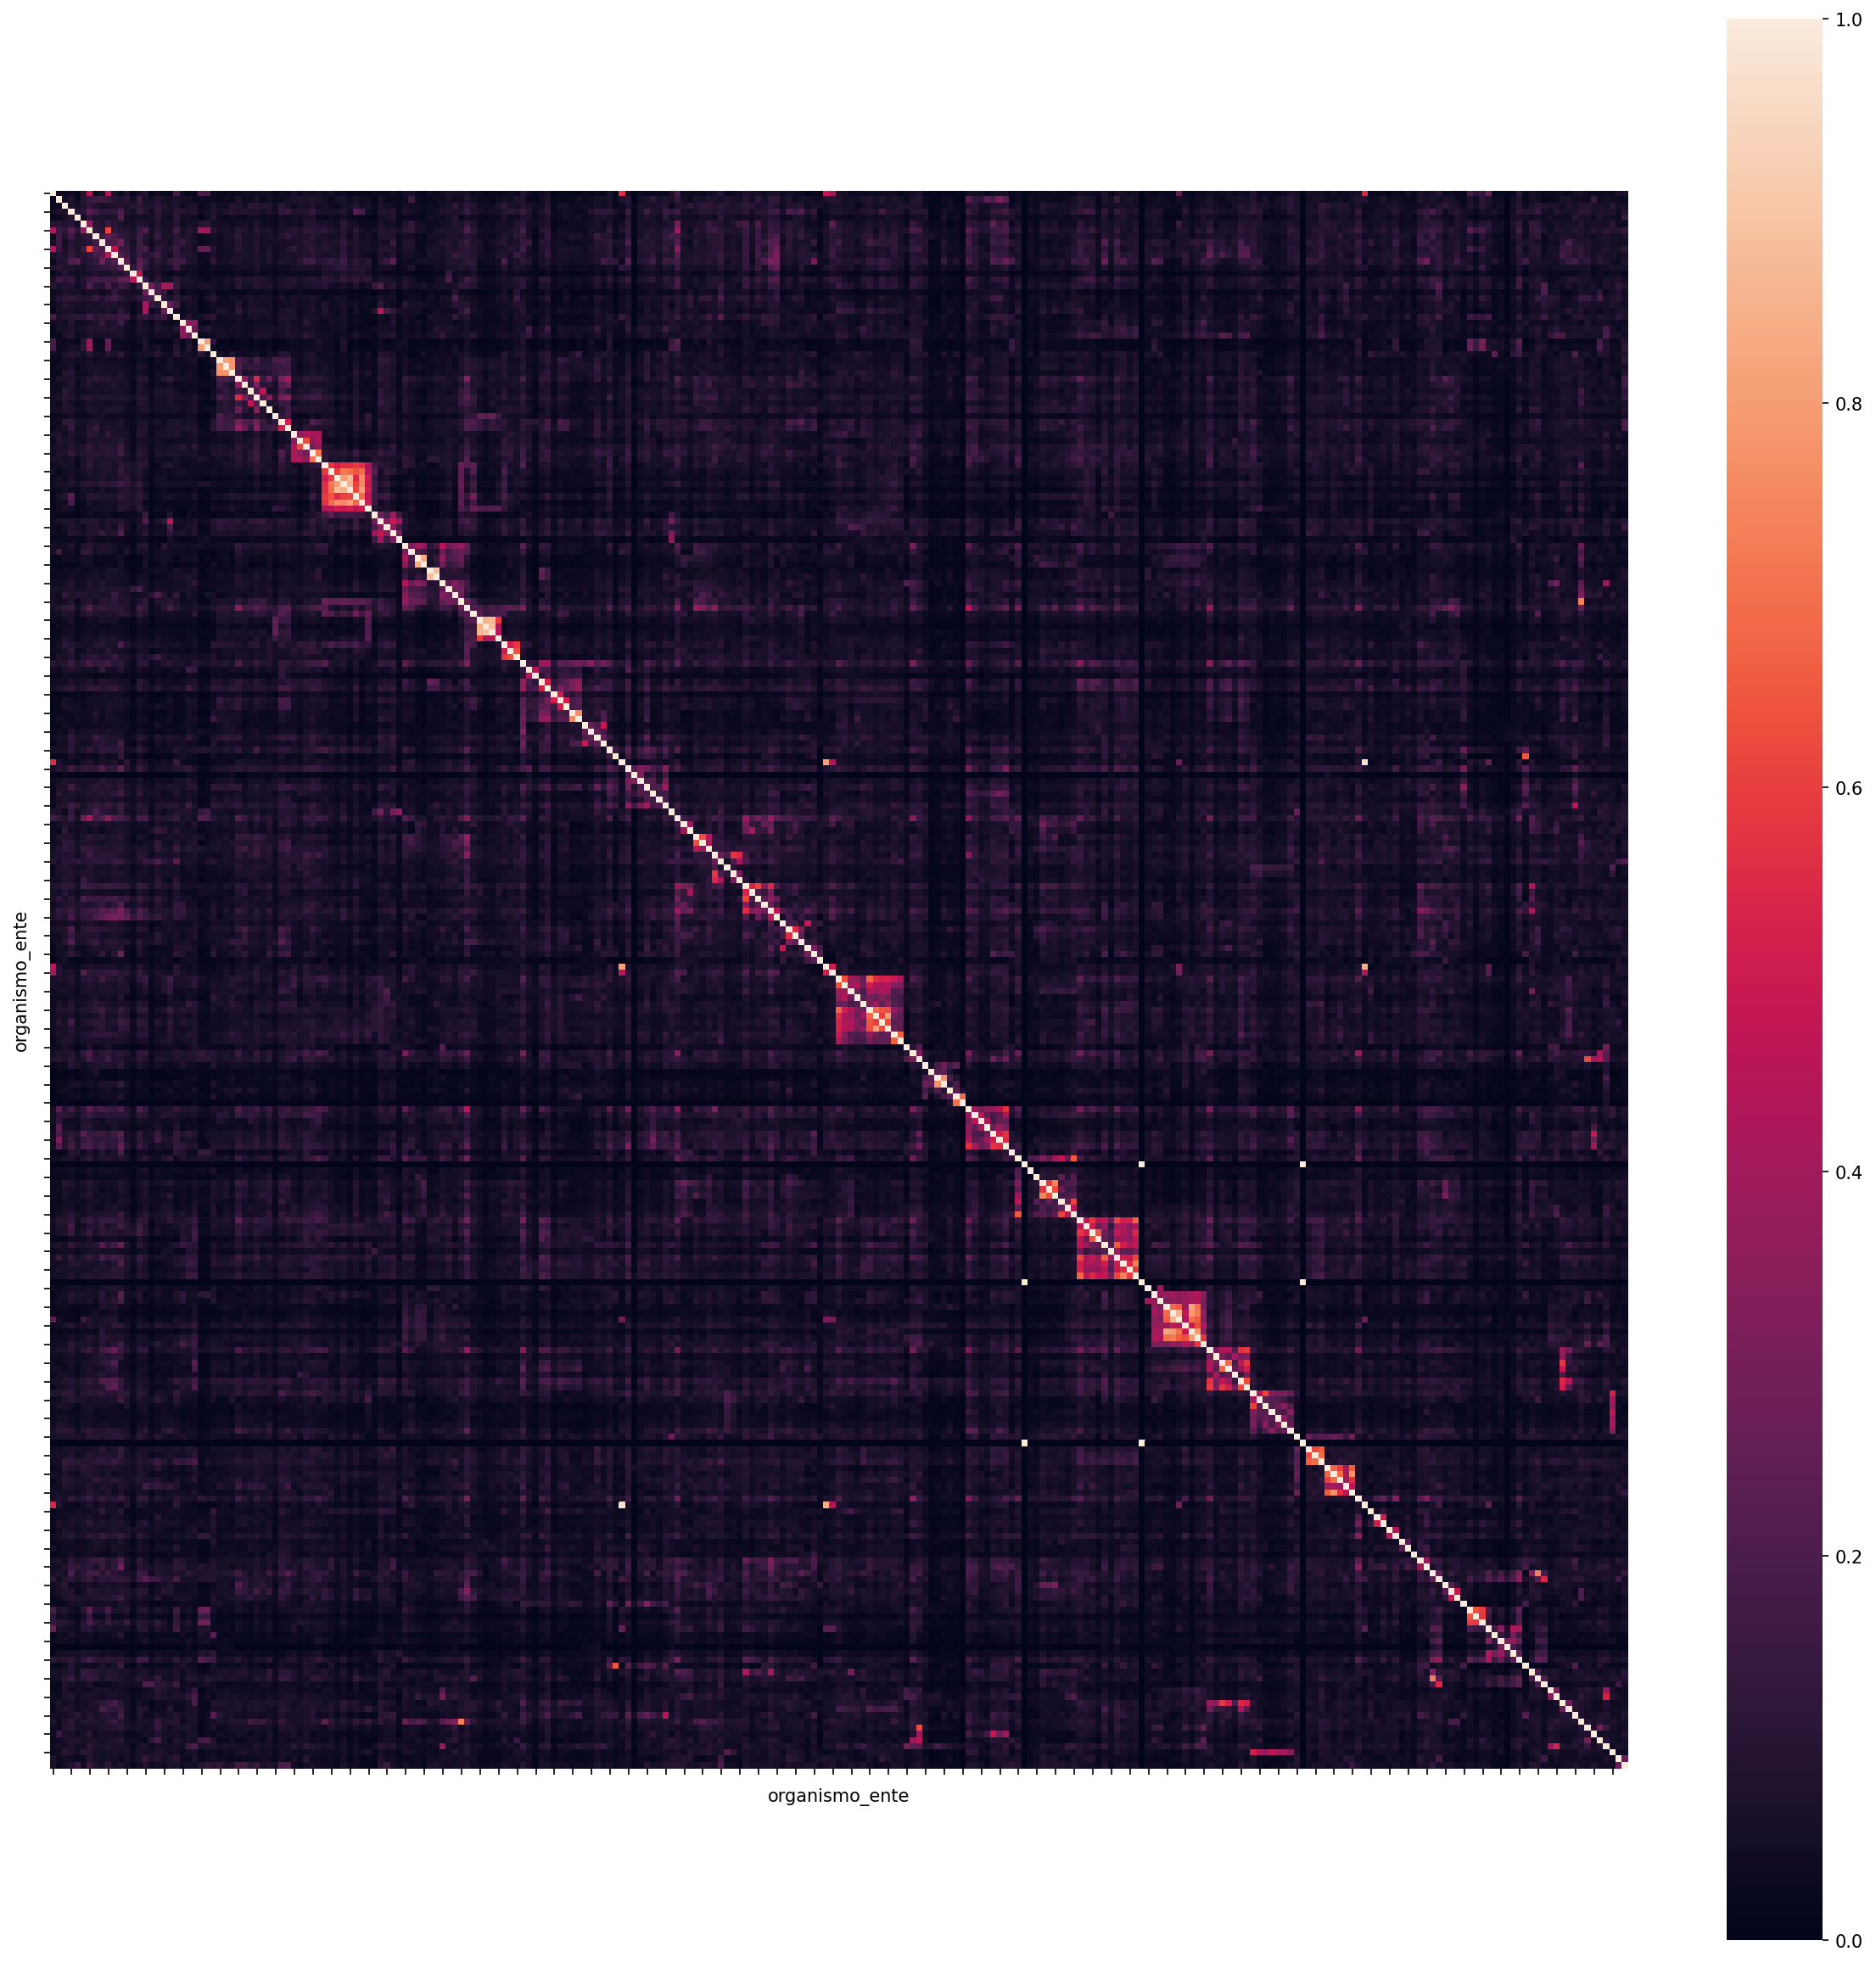

In [12]:
plt.figure(figsize=(20,20),dpi=150)
fig = sns.heatmap(tf_idf, square=True)
fig.set(xticklabels=[])
fig.set(yticklabels=[])
plt.savefig('heatmap.png')
plt.show()

#Agregar titulo, sacar leyendas, modificar el tamaño y agregar el gráfico interactivo.

In [22]:
#Tabla interactiva

#fig = px.imshow(tf_idf, width=2000, height=2000)
#fig.show()

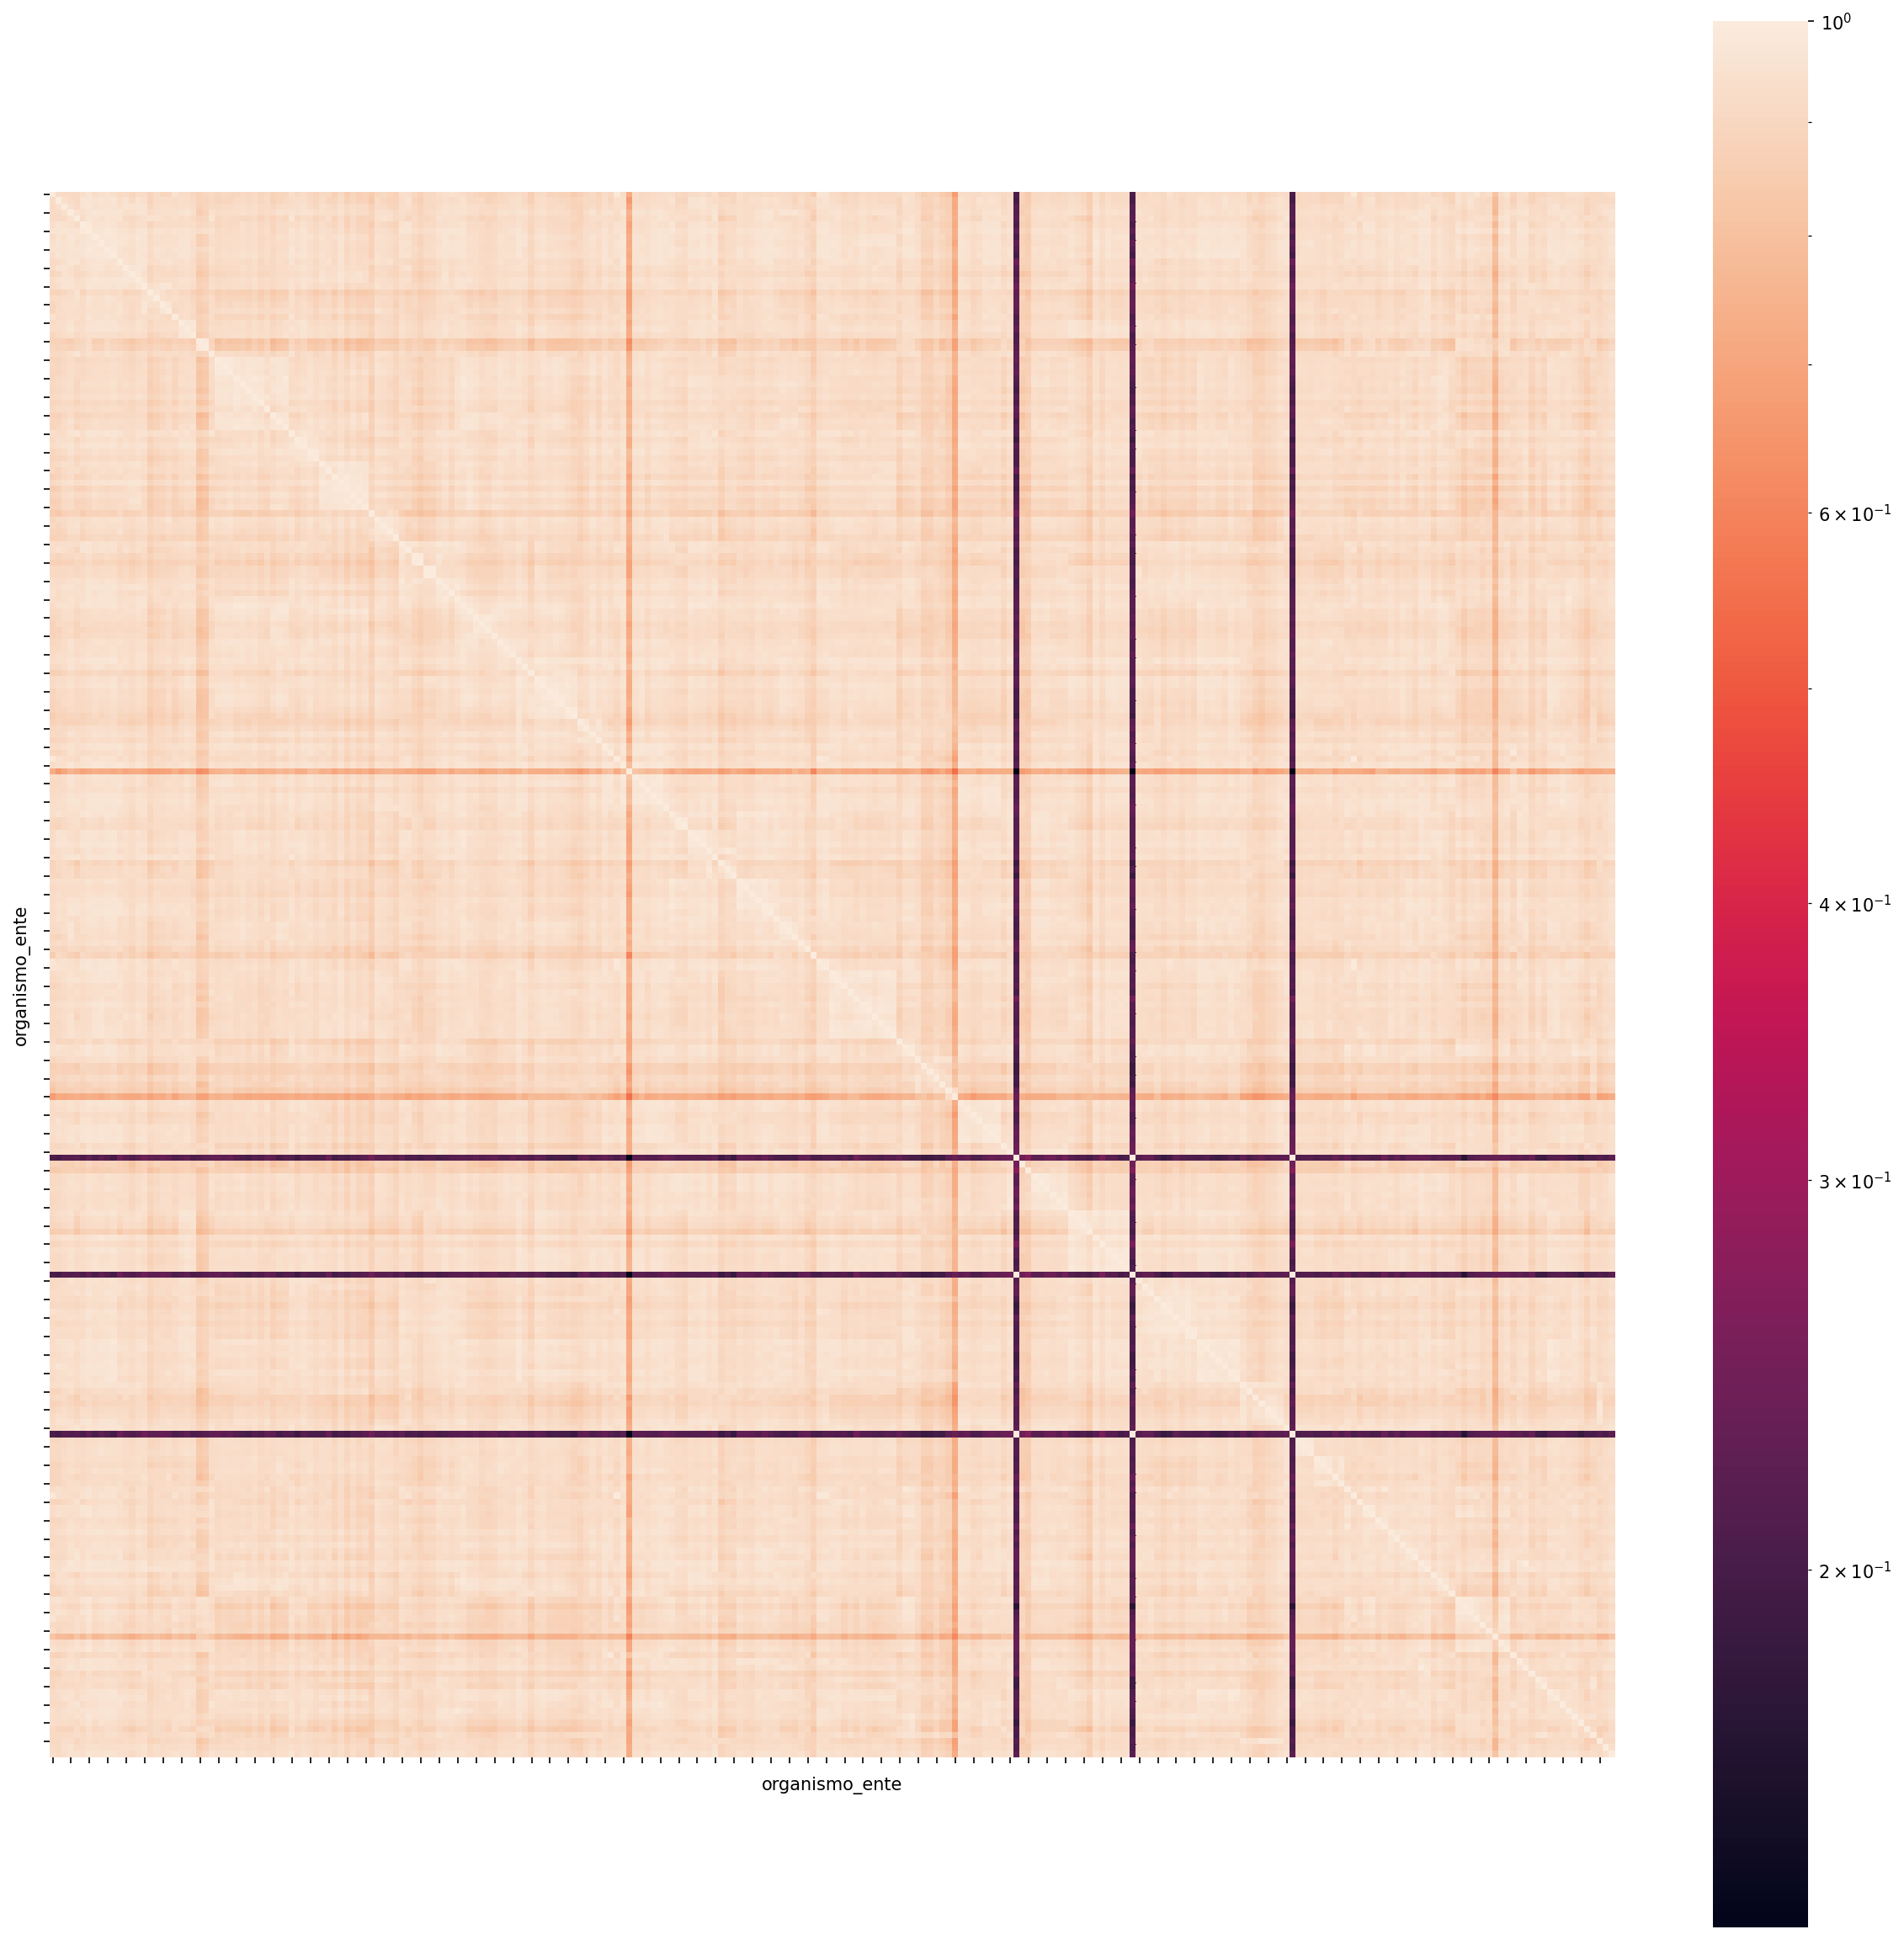

In [13]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(20,20),dpi=150)
fig = sns.heatmap(emb_df, square=True, norm=LogNorm())
fig.set(xticklabels=[])
fig.set(yticklabels=[])
plt.savefig('heatmap f.png')
plt.show()


--- 
## Distinguibilidad

El experto de dominio elaboró una lista de pares de dependencias, anotando cuáles tienen competencias distintas y cuáles tienen competencias solapadas.
Usando esta lista, podemos medir el rendimiento de diferentes aproximaciones para caracterizar las dependencias.  
Una aproximación será mejor si la forma como distingue las dependencias (medida de semejanza sobre vectores) permite separar las dependencias clasificadas manualmente como distintas y agrupar las dependencias clasificadas como competencias solapadas.

In [12]:
pares_simil = [["Subsecretaría de Coordinación Presupuestaria", "Subsecretaría de Presupuesto"],
["Secretaría de Asuntos Políticos", "Subsecretaría de Asuntos Políticos"],
["Secretaría de Política Ambiental en Recursos Naturales", "Secretaría de Cambio Climático"],
["subsecretaría de inclusión e integración social", "Secretaría de Hábitat"],
["subsecretaría de desarrollo de economías regionales", "subsecretaría de la productividad y desarrollo regional"],
["subsecretaría de políticas en ciencia, tecnología e innovación","secretaría de planeamiento y políticas en ciencia, tecnología e"],
["secretaría nacional de niñez, adolescencia y familia", "Subsecretaría de Primera Infancia"],
["subsecretaría de políticas para el desarrollo con equidad", "subsecretaría de programación regional y sectorial"],
["subsecretaría de medios públicos", "subsecretaría de gestión operativa de medios públicos"],
["Instituto Nacional de la Yerba Mate", "Instituto Nacional de Vitivinicultura"],
["Secretaría de Articulación de la Política Social", "Consejo Nacional de Coordinación de Políticas Sociales"],
["Ente Nacional Regulador de la Electricidad", "Ente Nacional Regulador del Gas"],
["Fondo Fiduciario para el Desarrollo de Energías Renovables", "Fondo Fiduciario para la Generación Distribuida de Energías Renovables"],
["Banco de la Nación Argentina", "Banco de Inversión y Comercio Exterior"],
["Contenidos Públicos S.E.", "Radio y Televisión Argentina S.E."],
["Secretaría de Promoción Turística del Ministerio de Turismo y Deportes", "Instituto Nacional de Promoción Turística"],
["Operadora Ferroviaria S.E.", "Ferrocarriles Argentinos S.E."],
["Comisión Nacional de Monumentos, de Lugares y de Bienes Históricos", "Secretaría de Patrimonio Cultural"]
]

pares_simil += [[p[1],p[0]] for p in pares_simil]

pares_diff = [["subsecretaría de inclusión e integración social", "Secretaría de Estrategia y Asuntos Militares"],
["Secretaría de Patrimonio Cultural", "subsecretaría de política minera"],
["subsecretaría de ingresos públicos", "Subsecretaría de Gestión Educativa y Calidad"],
["Subsecretaría de Ganadería y Producción Animal", "Secretaría de Seguridad y Política Criminal"],
["subsecretaría de ciberdefensa","subsecretaría de mercados agropecuarios"],
["subsecretaría de medios públicos","subsecretaría de primera infancia"],
["Agencia Federal de Inteligencia", "Fondo Fiduciario Federal de Infraestructura Regional"],
["Instituto Nacional de Estadística y Censos", "Intercargo S.A.U."],
["Ballet Nacional", "Subsecretaría de Agricultura del Ministerio de Agricultura"],
["Autoridad Regulatoria Nuclear", "Secretaría de Articulación Federal de la Seguridad del Ministerio de Seguridad"],
["Correo Oficial de la República Argentina S.A.", "Secretaría de Calidad en Salud del Ministerio de Salud"],
["Administración Federal de Ingresos Públicos", "Talleres Navales Dársena Norte"]
]

pares_diff += [[p[1],p[0]] for p in pares_diff]

In [13]:
def presition_k(k=10, pairs=pares_simil, df=tf_idf):
    acu = 0
    tot = 1
    for par in pairs:
        try:
            top_k = df[par[0].lower()].sort_values(ascending=False).head(k+1).index.tolist()
            if par[1].lower() in top_k:
                acu += 1
            tot += 1
        except KeyError:
            pass
        
    return acu/tot

In [14]:
presition_k(k=5), presition_k(k=10), presition_k(k=15), presition_k(k=20)

(0.2777777777777778, 0.4444444444444444, 0.5, 0.5)

In [21]:
presition_k(k=5, df=emb_df), presition_k(k=10, df=emb_df), presition_k(k=15, df=emb_df), presition_k(k=20, df=emb_df)

(0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333)

---
## Índice de solapamiento

El índice de solapamiento indica el grado de solapamiento de una dependencia con otras dependencias. Se obtiene como la media de semejanza con las k dependencias más cercanas.

Podemos rankear las dependencias por su índice de solapamiento, comparar el índice de solapamiento de diferentes subconjuntos de dependencias (obtenidos mediante las listas de n-gramas clave definidas por Martín), comparando el promedio de solapamiento de los documentos de cada subconjunto y con el promedio de solapamiento global

In [31]:
# dada una matriz de similaridad
similarity_kernel = similarity_kernel

# dado un k
k = 15

tops = []
for row in similarity_kernel:
    tops += [(-row).argsort()[:k+1][1:]]
        
top_vals = []
top_names = []
top_idxs = []
for i, top in enumerate(tops):
    row_vals = []
    row_names = []
    row_idxs = []
    #print(f"{hm_df.iloc[i]['organismo_ente']}")#, cantidad de Deps. > 0.5: {n_simil[i]}\n", file=f)
    for j in top:
        row_vals.append(similarity_kernel[i][j])
        row_names.append(df.iloc[j]["organismo_ente"])
        row_idxs.append(j)
        #print(f"\t {similarity_kernel[i][j]:.4f}", hm_df.iloc[j]["organismo_ente"])
    #print("")
    top_vals += [row_vals]
    top_names += [row_names]
    top_idxs += [row_idxs]

#esto es para los top K valores, no para el total
isol = [sum(x)/len(x) for x in top_vals]
stdev = [statistics.stdev(x) for x in top_vals]

#isol(dep, prom(isol), stdev, top10 list)
df["isol"] = isol
df["stdev"] = stdev
df["most_similar(names)"] = top_names
df["most_similar(values)"] = top_vals
df["most_similar(indexes)"] = top_idxs

#obetener el prom y stdev de todo
isol_prom = sum(isol)/len(isol)
isol_stdev = statistics.stdev(isol)

#ordenar por isol
#isol_df = isol_df.sort_values(by="isol", ascending=False)


<AxesSubplot:xlabel='topic', ylabel='isol'>

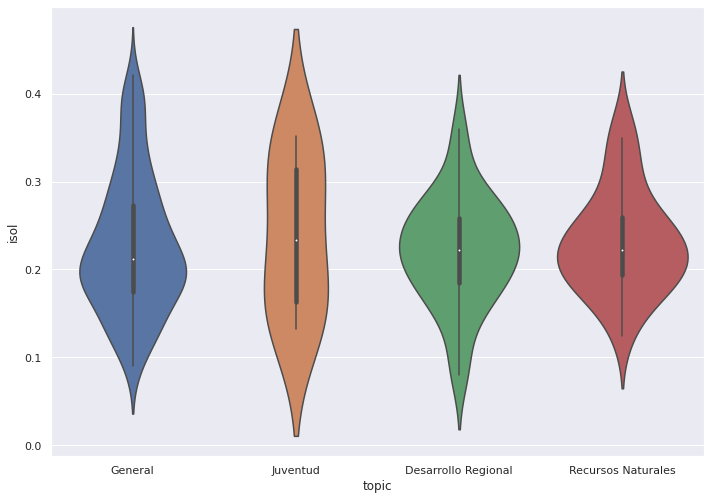

In [29]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.violinplot(x=df["topic"], y=df["isol"])

### Solapamiento con dependencias externas (por Raiz y por tópico)

El índice de solapamiento externo es el promedio de semejanza de una dependencia con todas las dependencias que no forman parte de su tópico (definido por las palabras clave que dio el experto de dominio) o bien que no tienen la misma dependencia raíz

In [19]:
df['raiz'].unique()

array(['jefatura de gabinete de ministros',
       'ministerio de agricultura, ganaderia y pesca',
       'ministerio de agricultura, ganadería y pesca',
       'ministerio de ambiente y desarrollo sostenible',
       'ministerio de ambiente y desarrollo sostenible,',
       'ministerio de ciencia, tecnología e innovación',
       'ministerio de cultura', 'ministerio de defensa',
       'ministerio de desarrollo productivo',
       'ministerio de desarrollo social',
       'ministerio de desarrollo territorial y hábitat',
       'ministerio de economía', 'ministerio de educación',
       'ministerio de justicia y',
       'ministerio de justicia y derechos humanos',
       'ministerio de las mujeres, géneros y diversidad',
       'ministerio de obras públicas', 'ministerio de relaciones',
       'ministerio de relaciones exteriores, comercio internacional y culto',
       'ministerio de salud', 'ministerio de seguridad',
       'ministerio de trabajo, empleo y seguridad social',
      

In [23]:
df.head()

,organismo_ente,reporta_a,proc_text,raw_text,centralizado,raiz,secretaria,topic
18,secretaría de coordinación administrativa,jefatura de gabinete de ministros,asistir jefe gabinete ministro diseño presupue...,1. asistir al jefe de gabinete de ministros en...,true,jefatura de gabinete de ministros,secretaría de coordinación administrativa,General
26,oficina nacional de contrataciones,secretaría de coordinación presupuestaria y pl...,proponer política contratación organización si...,1. proponer políticas de contrataciones y de o...,true,jefatura de gabinete de ministros,secretaría de coordinación presupuestaria y pl...,General
25,subsecretaría de telecomunicaciones y conectiv...,secretaría de coordinación presupuestaria y pl...,asistir secretaría diseño política regulación ...,1. asistir a la secretaría en el diseño de pol...,true,jefatura de gabinete de ministros,secretaría de coordinación presupuestaria y pl...,General
24,subsecretaría de programación y prospectiva,secretaría de coordinación presupuestaria y pl...,asistir secretaría programación coordinación s...,"1. asistir a la secretaría en la programación,...",true,jefatura de gabinete de ministros,secretaría de coordinación presupuestaria y pl...,General
23,subsecretaría de coordinación política e insti...,secretaría de coordinación presupuestaria y pl...,participar diseño coordinación política públic...,1. participar en el diseño y coordinación de p...,true,jefatura de gabinete de ministros,secretaría de coordinación presupuestaria y pl...,General


In [26]:
similarity_kernel[df['organismo_ente']=='subsecretaría de programación y prospectiva'][0][df['raiz']!='jefatura de gabinete de ministros'].mean()

0.08019215214901838

In [33]:
def calculate_isolR(x):
    similarities = similarity_kernel[df['organismo_ente']==x['organismo_ente']][0]
    return(similarities[df['raiz']!=x['raiz']].mean())
df["isolExtR2"] = df.apply(lambda x: calculate_isolR(x),axis=1)

In [38]:
df[df['raiz'] == 'ministerio de salud'].shape

(10, 16)

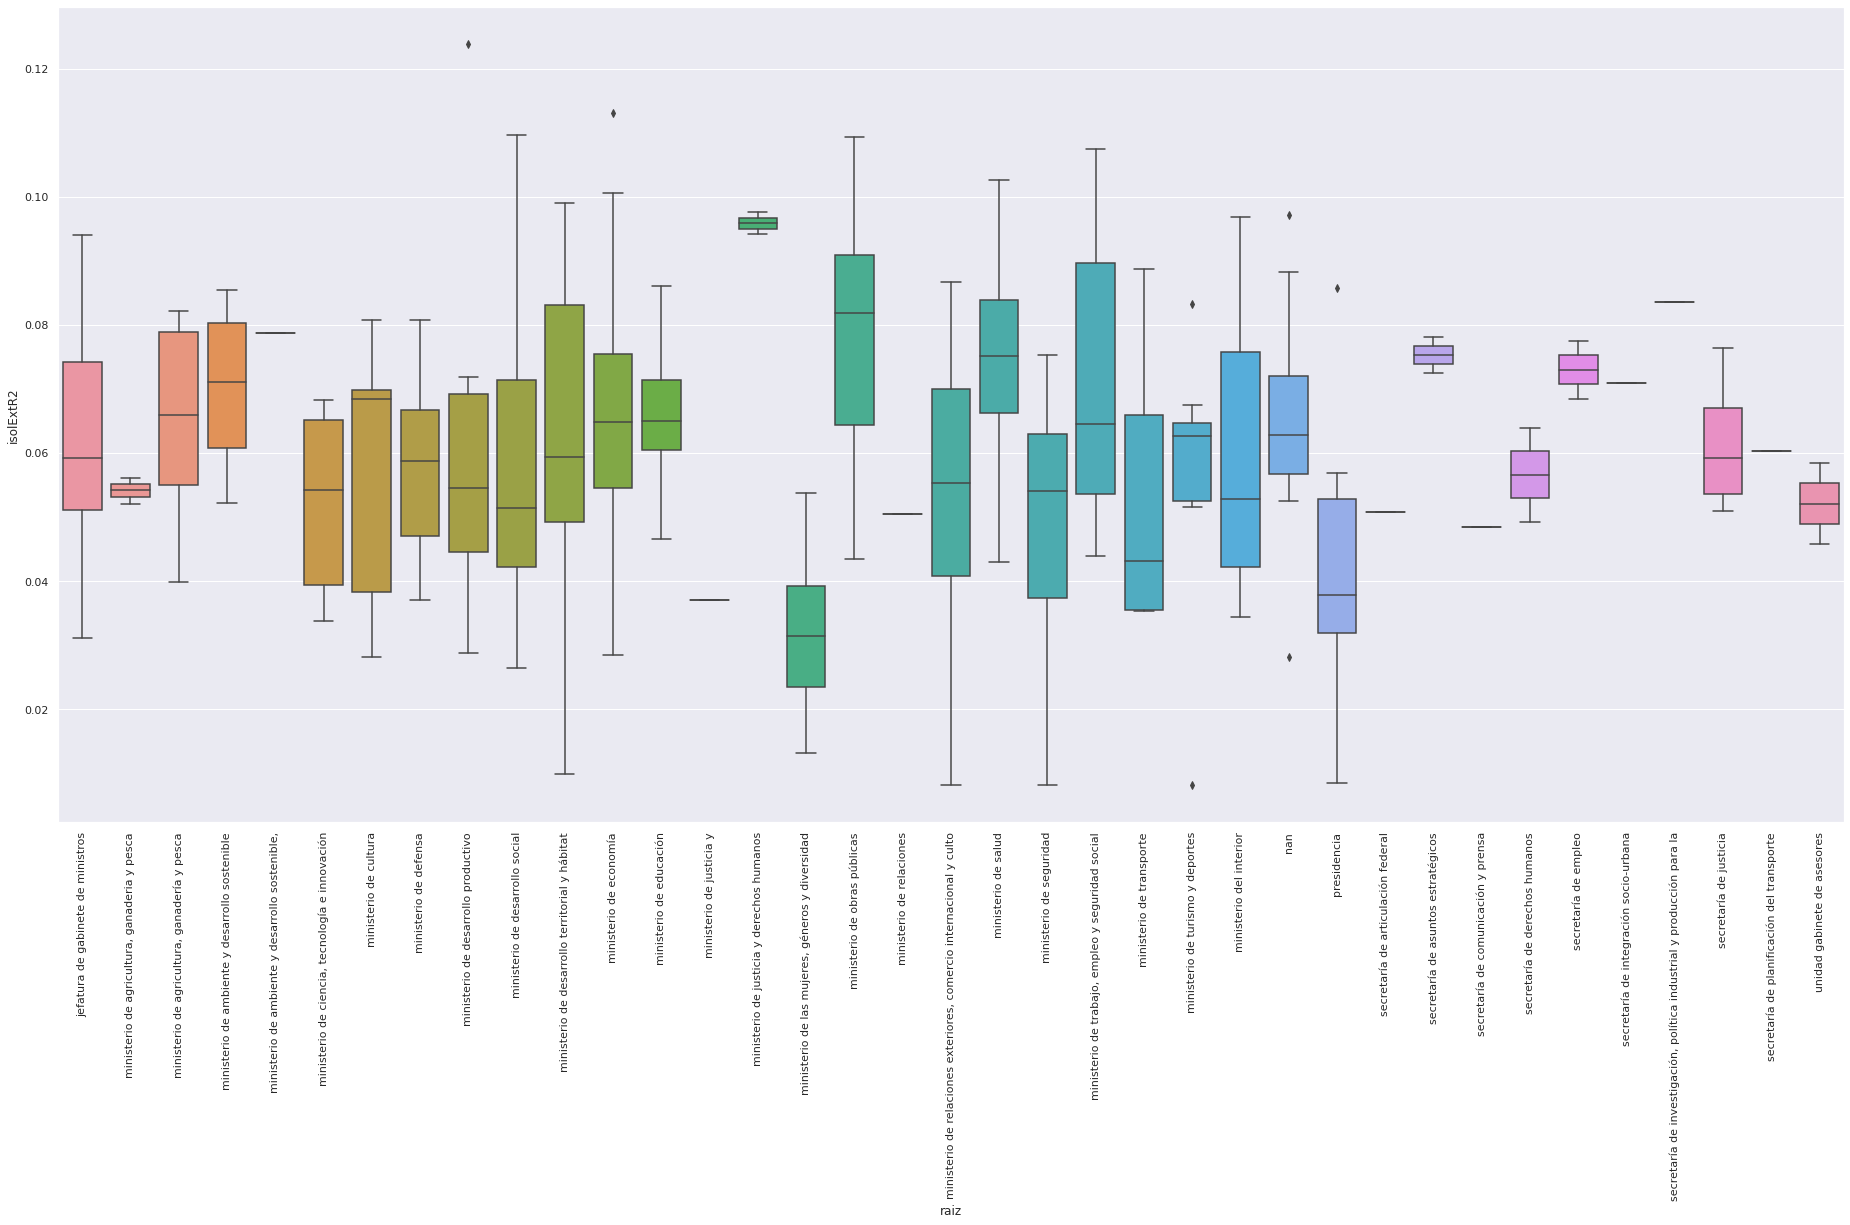

In [36]:
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(32,15)})
fig = sns.boxplot(x=df["raiz"], y=df["isolExtR2"])
fig.set_xticklabels(fig.get_xticklabels(),rotation = 90)
plt.savefig('indice_sol_externo.png')

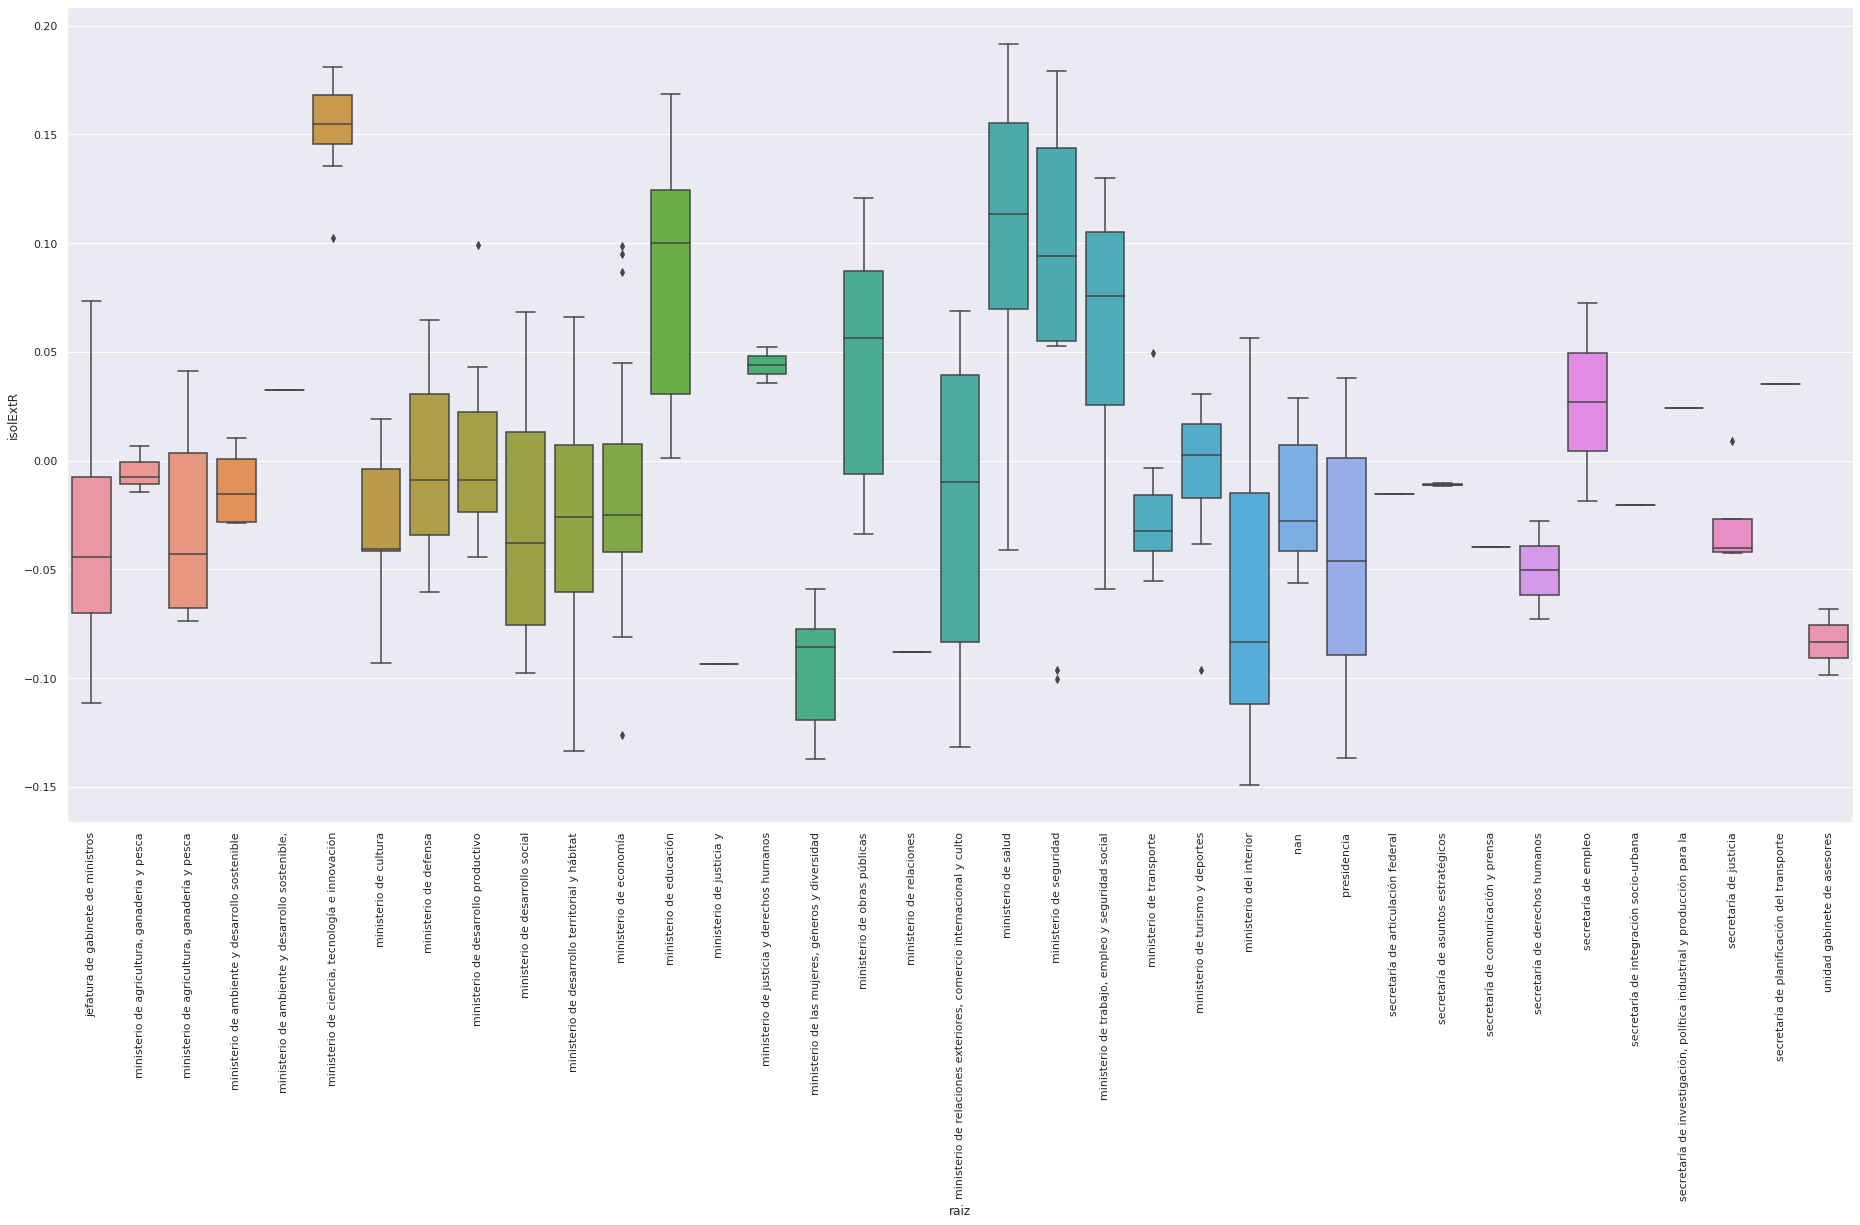

In [32]:
isol_raices = df.groupby("raiz")["isol"].mean()
isol_raiz_comp = isol_raices.copy()
isol_topic = df.groupby("topic")["isol"].mean()
isol_topic_comp = isol_topic.copy()

df["isolExtT"] = 0
df["isolExtR"] = 0
    
#calculamos el promedio de isol del complemento segun raiz o topic
for raiz in isol_raices.index:
    isol_raiz_comp[raiz] = isol_raiz_comp[isol_raiz_comp.index != raiz].mean()

for topic in isol_raices.index:
    isol_raiz_comp[topic] = isol_topic_comp[isol_topic_comp.index != topic].mean()

def get_isolExt(x):
    x["isolExtT"] = x["isol"] - isol_topic_comp[x["topic"]]
    x["isolExtR"] = x["isol"] - isol_raiz_comp[x["raiz"]]
    return x

df = df.agg(get_isolExt, axis=1)

sns.set(rc={'figure.figsize':(32,15)})
fig = sns.boxplot(x=df["raiz"], y=df["isolExtR"])
fig.set_xticklabels(fig.get_xticklabels(),rotation = 90)
pass

## umbral de semejanza
A partir de los pares de entidades semejantes (y no semejantes) definidos por el experto de dominio, obtuvimos un número de corte que nos sirve para discriminar cuándo un par de dependencias tiene solapamiento y cuándo no

In [43]:
umbral = df.isol.mean()#, isol_df[isol_df.str.contains]
umbral

0.22698258560003245

## Visualización del solapamiento en base al umbral

Similar a las visualizaciones anteriores, aqui se busca mostrar las dependencias que estan por encima del umbral, lo que nos permite encontrar los organismos que no pertenezcan a un mismo ministerio pero que sus objetivos pueden solaparse.

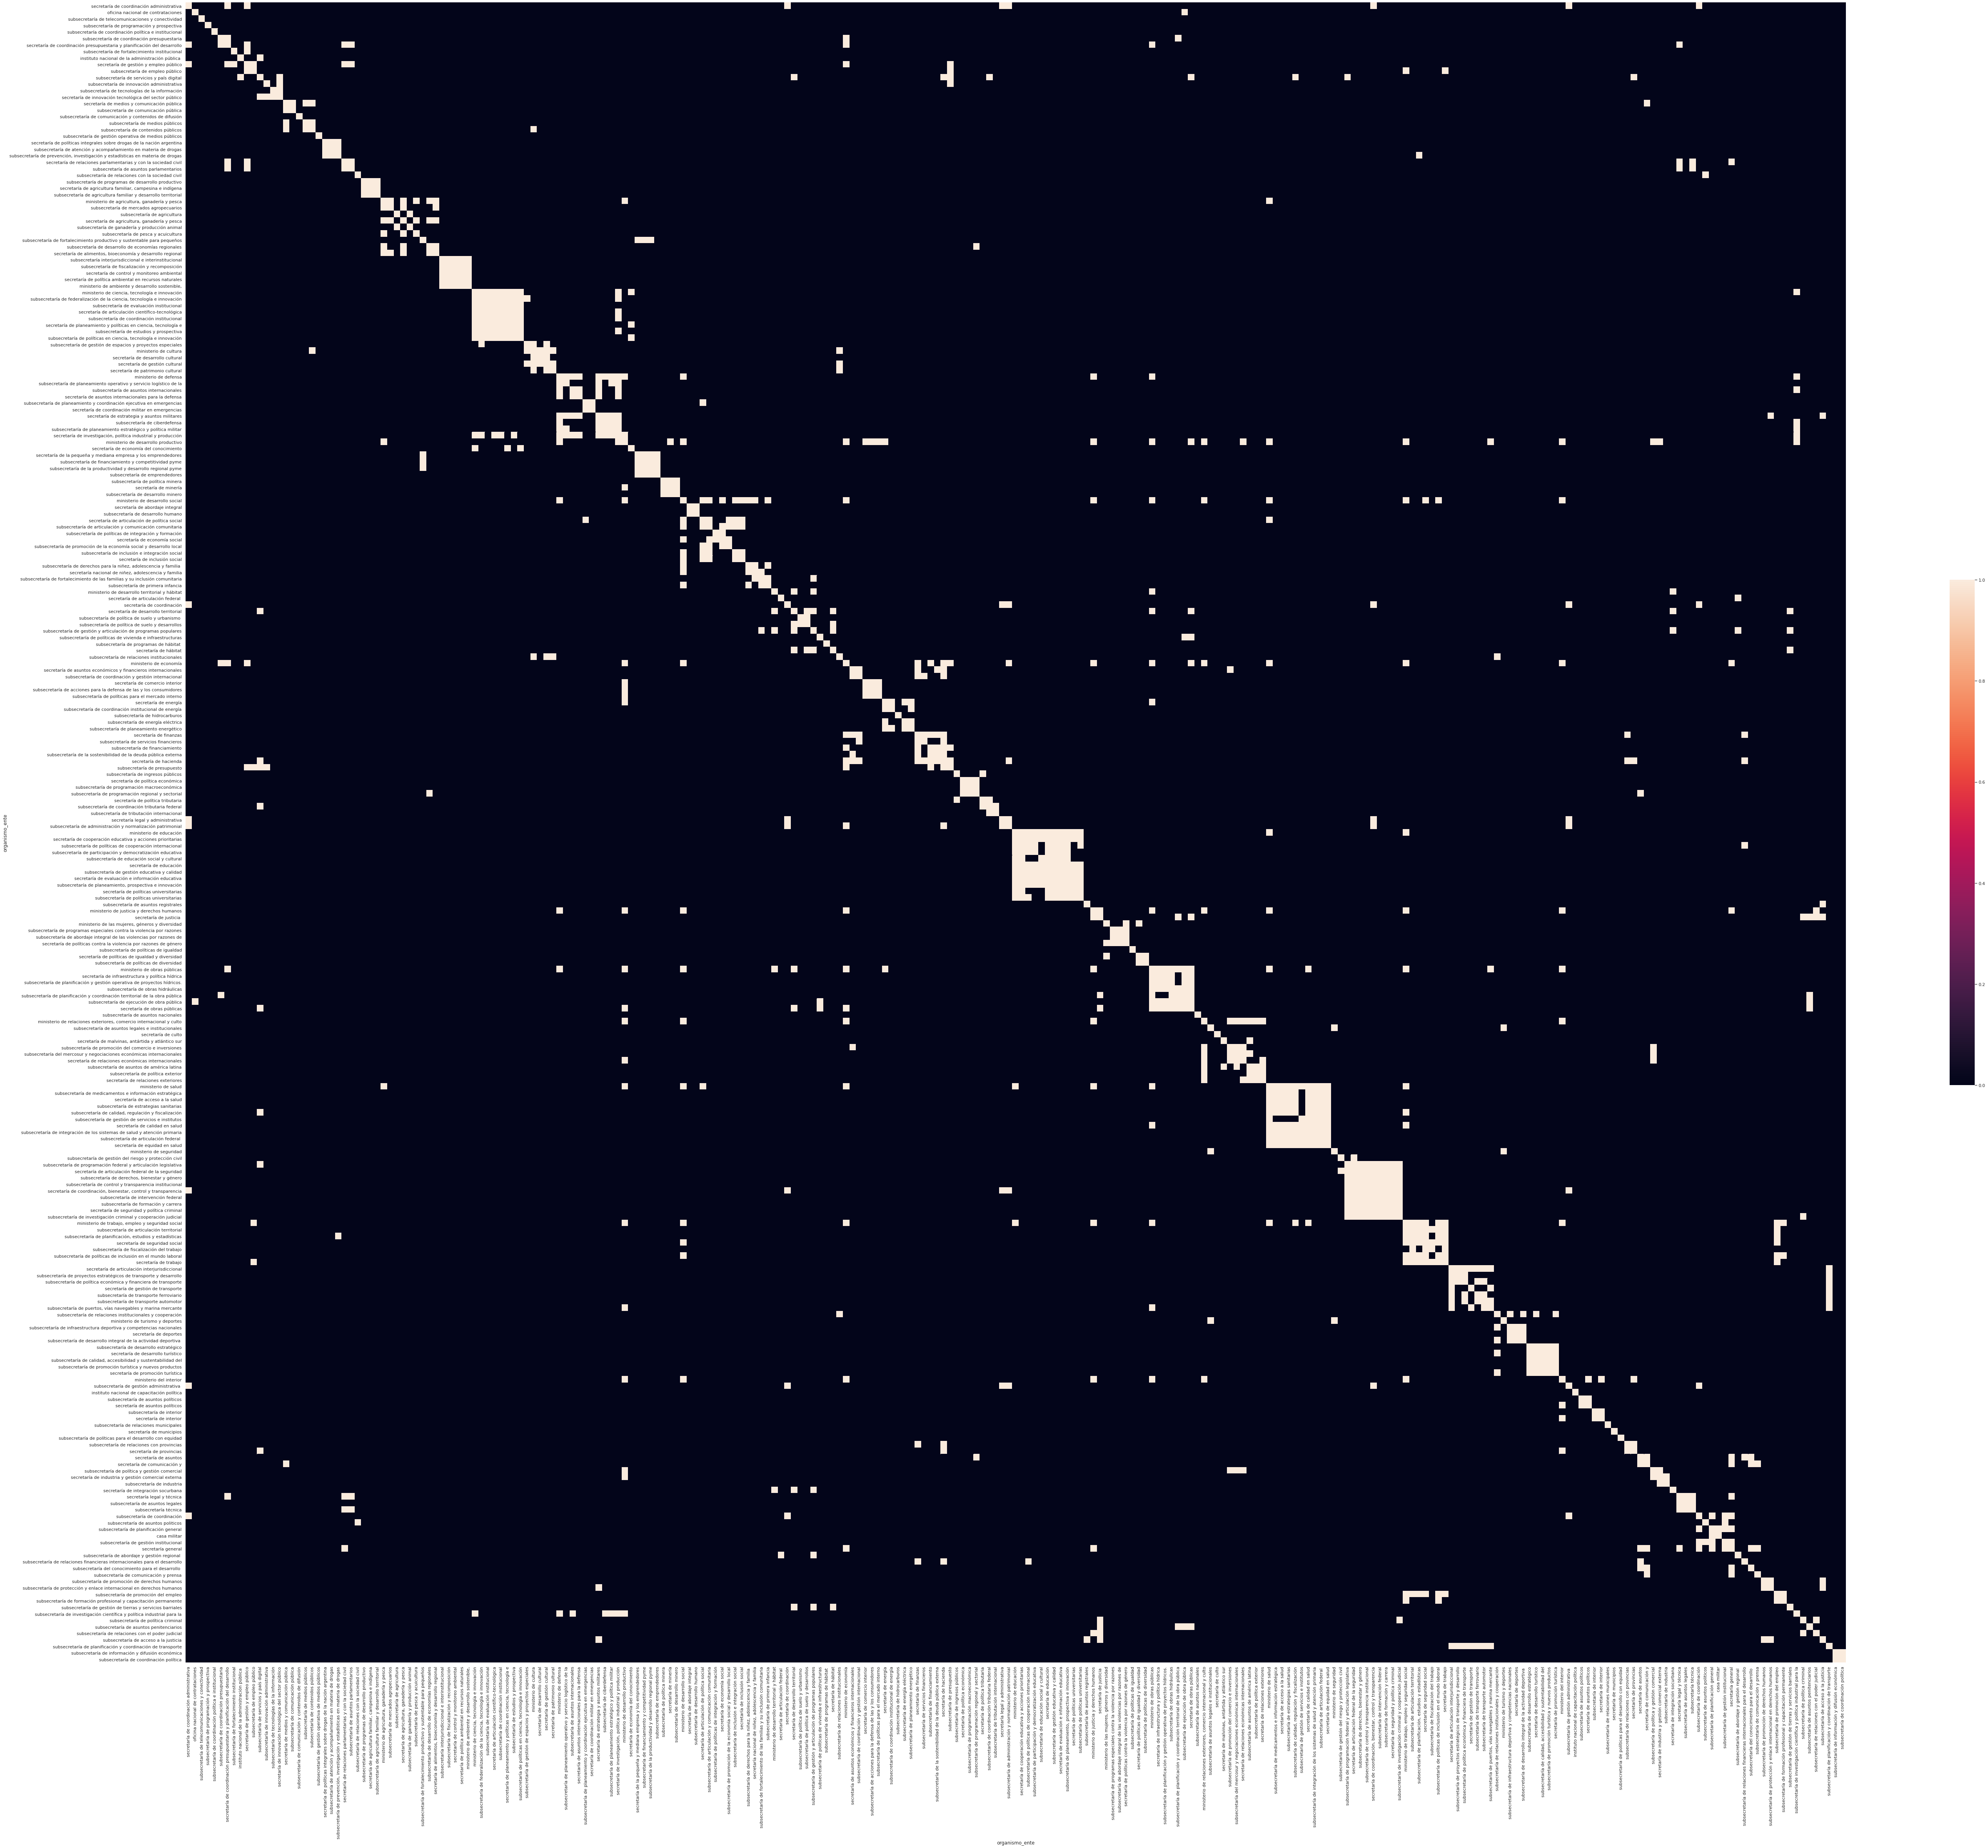

In [25]:
#son semejantes x e y? hacer un heatmap binario
sk = similarity_kernel.copy()
sk[sk < umbral] = 0
sk[sk >= umbral] = 1

sk_df = pd.DataFrame(sk, index=df["organismo_ente"], columns=df["organismo_ente"])

plt.figure(figsize=(95,95))

sns.heatmap(sk_df, cbar_kws={"shrink": 0.25}, square=True)
plt.savefig('similaridades.jpeg')
plt.show()

In [62]:
sk = similarity_kernel.copy()
sk[sk < umbral] = 0
sk[sk >= umbral] = 1

sk_df = pd.DataFrame(sk, index=df["organismo_ente"], columns=df["organismo_ente"])

In [63]:
data = []
for x in range(0,255):
    for y in range(x+11,255):
        if sk_df.iloc[x,y] == 1:
            dependencia_1 = sk_df.index[x]
            reporta_1 = df[df['organismo_ente'] == sk_df.index[x]]['reporta_a'].values[0]
            descripcion_1 = df[df['organismo_ente'] == sk_df.index[x]]['raw_text']
            
            reporta_2 = df[df['organismo_ente'] == sk_df.columns[y]]['reporta_a'].values[0]
            descripcion_2 = df[df['organismo_ente'] == sk_df.columns[y]]['raw_text'].values[0]
            dependencia_2 = sk_df.columns[y]
            
            match = [dependencia_1,reporta_1,descripcion_1,dependencia_2,reporta_2,descripcion_2]
            data.append(match)

In [64]:
solapamientos = pd.DataFrame(data, columns=['Dependencia 1','Reporta a (1)', 'Descripcion 1', 'Dependencia 2','Reporta a (2)', 'Descripcion 2'])
solapamientos.shape

(204, 6)

In [65]:
solapamientos.head(20)

,Dependencia 1,Reporta a (1),Descripcion 1,Dependencia 2,Reporta a (2),Descripcion 2
0,secretaría de coordinación administrativa,jefatura de gabinete de ministros,18 1. asistir al jefe de gabinete de minist...,secretaría de coordinación,ministerio de desarrollo territorial y hábitat,1. dirigir y coordinar el desarrollo de las ac...
1,secretaría de coordinación administrativa,jefatura de gabinete de ministros,18 1. asistir al jefe de gabinete de minist...,secretaría legal y administrativa,ministerio de economía,1. dirigir y coordinar el desarrollo de las ac...
2,secretaría de coordinación administrativa,jefatura de gabinete de ministros,18 1. asistir al jefe de gabinete de minist...,subsecretaría de administración y normalizació...,secretaría legal y administrativa,1. asistir en el diseño de la política presupu...
3,secretaría de coordinación administrativa,jefatura de gabinete de ministros,18 1. asistir al jefe de gabinete de minist...,"secretaría de coordinación, bienestar, control...",ministerio de seguridad,1. asistir al/a la ministro/a en todos los asp...
4,secretaría de coordinación administrativa,jefatura de gabinete de ministros,18 1. asistir al jefe de gabinete de minist...,subsecretaría de gestión administrativa,ministerio del interior,1. dirigir y coordinar el desarrollo de las ac...
5,secretaría de coordinación administrativa,jefatura de gabinete de ministros,18 1. asistir al jefe de gabinete de minist...,subsecretaría de coordinación,secretaría general,"1. entender en el asesoramiento, coordinación ..."
6,oficina nacional de contrataciones,secretaría de coordinación presupuestaria y pl...,26 1. proponer políticas de contrataciones ...,subsecretaría de ejecución de obra pública,secretaría de obras públicas,1. asistir a la secretaría en la ejecución de ...
7,subsecretaría de coordinación presupuestaria,secretaría de coordinación presupuestaria y pl...,22 1. asesorar a la secretaría para la coor...,ministerio de economía,nan,"1. ejecutar los planes, programas y proyect..."
8,subsecretaría de coordinación presupuestaria,secretaría de coordinación presupuestaria y pl...,22 1. asesorar a la secretaría para la coor...,subsecretaría de planificación y coordinación ...,secretaría de obras públicas,1. asistir a la secretaría en la elaboración y...
9,secretaría de coordinación presupuestaria y pl...,jefatura de gabinete de ministros,21 1. asistir al jefe de gabinete de minist...,secretaría de relaciones parlamentarias y con ...,jefatura de gabinete de ministros,1. diseñar e implementar las relaciones parlam...


In [66]:
solapamientos.to_csv('solapamientos.csv')

## Conclusión Final

Se logró obetener una versión inicial de todo el proceso. Se extrajeron los documentos necesarios y se procesó el texto para hacer el análisis, se obtuvo una métrica  que nos permite medir solapamiento de competencias, y se realizaron representaciones que nos dejan concluir que se va por buen camino.
